In [ ]:
import numpy as np
from scipy import optimize
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import cvxpy as cp
from tqdm import tqdm

## Problème primal 

In [ ]:
def func_to_minimize(x):
    n=len(x)
    return sum([np.exp(x[i-1]) + (i/n)*x[i-1] for i in range(1,n+1)])

In [ ]:
tab_N= [10,100,200,400,600]
tab_mins_pr,tab_x_pr,tab_time_pr,tab_x_comp_pr=[],[],[],[]
for N in tab_N : 
    A=np.array([1 for i in range(N)])
    constr=optimize.LinearConstraint(A=A,lb=1,ub=np.inf)
    x0=np.random.normal(0,1,N)
    
    t0=time.time()
    res=optimize.minimize(func_to_minimize, x0=x0, constraints=constr, method='trust-constr', tol=1e-6)
    t1=time.time()
    
    tab_mins_pr.append(res.fun)
    tab_x_pr.append(np.linalg.norm(res.x))
    tab_x_comp_pr.append(res.x) ## composante de x 
    tab_time_pr.append(t1-t0)
    


## Problème dual 

In [ ]:
def lagrangien(lambda_,n) :
    return sum([(lambda_-(i/n))+(i/n-lambda_)*np.log(lambda_-i/n) for i in range(1,n+1)]) + lambda_

Dans cette cellule , on trace la courbe pour un certains nombre de points pour avoir une idée grossière sur la position du maximum.

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


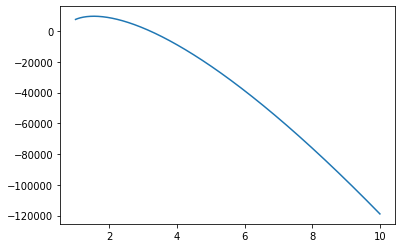

In [ ]:
lambda_=np.linspace(0,10,1000)
plt.plot(lambda_,lagrangien(lambda_,10000))

In [ ]:
tab_N= [10,100,200,400,600]
tab_mins,tab_x,tab_time,tab_x_comp_duale=[],[],[],[]

## Définition de la contrainte : lambda >=1
constr=optimize.LinearConstraint(A=1,lb=1,ub=np.inf)

for N in tab_N : 

    ## d'après le graphe ci dessus , le max est atteint pour un lambda autour de 2. Donc pour trouver x0 on 
    ## échantillone une loi normale de moyenne 2 et d'écart type 0.5
    x0=np.random.normal(2,0.5,1)
    t0=time.time()
    res=optimize.minimize(lambda x: -lagrangien(x,N), x0=x0, constraints=constr, method='trust-constr', tol=1e-6)
    t1=time.time()
    
    X_n=np.array([np.log(res.x-i/N) for i in range(1,N+1)])
        
    tab_mins.append(func_to_minimize(X_n)[0])
    tab_x.append(np.linalg.norm(X_n))
    tab_x_comp_duale.append(X_n)
    tab_time.append(t1-t0)

# Résultats 

### Problème primal 

In [ ]:
pd_table=pd.DataFrame([tab_mins_pr,tab_x_pr,tab_time_pr],columns=['N=10','N=100','N=200','N=400','N=600'],
                     index=['f_min','norm x_min','execution time (s)'])
pd_table

,N=10,N=100,N=200,N=400,N=600
f_min,11.227287,97.367947,193.178331,384.806779,576.436939
norm x_min,0.890750,2.908776,4.133347,5.860022,7.183111
execution time (s),0.086954,1.892384,14.844751,89.464949,49.694661


### Problème dual 

In [ ]:
## convert to table 

pd_table=pd.DataFrame([tab_mins,tab_x,tab_time],columns=['N=10','N=100','N=200','N=400','N=600'],
                     index=['f_min','norm x_min','execution time (s)'])
pd_table


,N=10,N=100,N=200,N=400,N=600
f_min,11.227676,97.370179,193.178417,384.807228,576.436932
norm x_min,0.890757,2.908738,4.133347,5.860020,7.183106
execution time (s),0.022780,0.025555,0.051040,0.045466,0.068177


On retrouve les mêmes résultats pour le minimum de f pour différents N . Par contre , la restriction du problème d'optimisation à une variable a permis une résolution très rapide ( 0.045 secondes ici contre 89 secondes précédemment pour N = 400 par exemple ). Ceci est dû au fait que le problème dual est univarié , donc on résout sur $R$ alors que pour le problème primal on résout sur $R^{n}$.

## comparaison entre les x_min 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


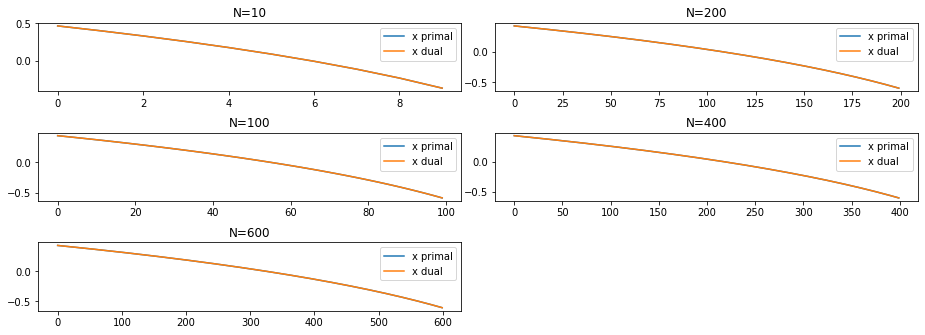

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 5))
fig.delaxes(ax[2,1])
tab_axes=[[0,0],[1,0],[0,1],[1,1],[2,0]]

for i,N in enumerate(tab_N) :
    x_primal,x_dual=tab_x_comp_pr[i],tab_x_comp_duale[i]
    
    k,j=tab_axes[i]
    ax[k][j].plot(range(N),x_primal,label="x primal")
    ax[k][j].plot(range(N),x_dual, label= "x dual")
    ax[k][j].legend(loc="upper right")
    plt.legend()
    ax[k][j].set_title('N={}'.format(N))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()  

$ \forall N $, les graphes des composantes de $x_{min}$ se superposent , donc on retrouve bien les mêmes minimums. 

## 2 - Optimisation discrète 

In [ ]:
## Ici changer le path pour lire le csv.
casiers_df=pd.read_csv('/home/hamza/PositionCasiers.txt', sep='\t')
objets_df=pd.read_csv('/home/hamza/PositionObjets.txt', sep='\t')

## Solve 

In [ ]:
def func_to_minimize(x,casiers_df,objets_df) :
    n=len(casiers_df)
    s=0
    for i in range(n):
        for j in range(n): 
            s+=x[i][j]*np.linalg.norm(casiers_df.loc[i].values-objets_df.loc[j].values)
    return s

    

In [ ]:

n=len(casiers_df)
x = cp.Variable((n,n),boolean=True)

objective = cp.Minimize(func_to_minimize(x,casiers_df,objets_df) )


constraints1 = [cp.sum(x[:,j])==1 for j in range(n)]
constraints2 = [cp.sum(x[i,:])==1 for i in range(n)]
constraints_all_2=constraints1+constraints2
prob = cp.Problem(objective,constraints_all_2)

result = prob.solve(verbose=False,solver='ECOS_BB')

print('La distance optimale est ',prob.value)
print(' x minimal est ',np.round(x.value, 1))

La distance optimale est  15.377627810052122
 x minimal est  [[-0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  1.  0.  0.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  1.  0.  0. -0.]
 [-0.  0.  1. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  1. -0.]
 [-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  1.]
 [ 1.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.

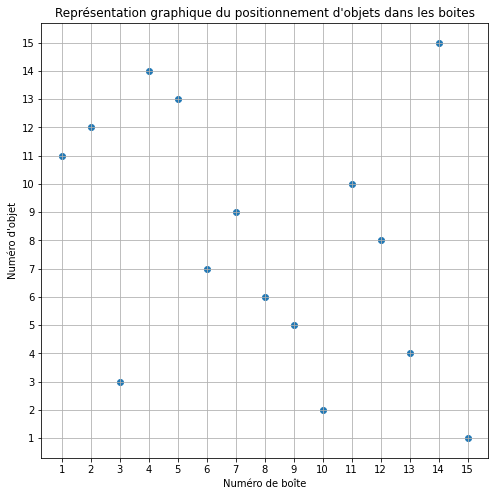

In [ ]:
## Représentation graphique

plt.figure(figsize=(8,8))
row_ix = np.where(np.round(x.value, 1) == 1.)
plt.scatter(row_ix[0]+1,row_ix[1]+1)
plt.xticks(list(range(1,n+1)))
plt.yticks(list(range(1,n+1)))

plt.grid(True)
plt.xlabel('Numéro de boîte')
plt.ylabel("Numéro d'objet")
plt.title("Représentation graphique du positionnement d'objets dans les boites")
plt.show()

## Question 3 

In [ ]:
constr3=[x[i,1]==x[i-1,0] for i in range(1,n) ]
constraints_all_3=constraints_all_2+constr3
prob = cp.Problem(objective,constraints_all_3)

result = prob.solve(verbose=False,solver='ECOS_BB')

print('La distance optimale est ',prob.value)
print(' x minimal est ',np.round(x.value, 1))

La distance optimale est  15.565123298218959
 x minimal est  [[-0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  1.  0.  0.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  1.  0.  0. -0.]
 [-0. -0.  1. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  1.  0. -0.]
 [ 0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.

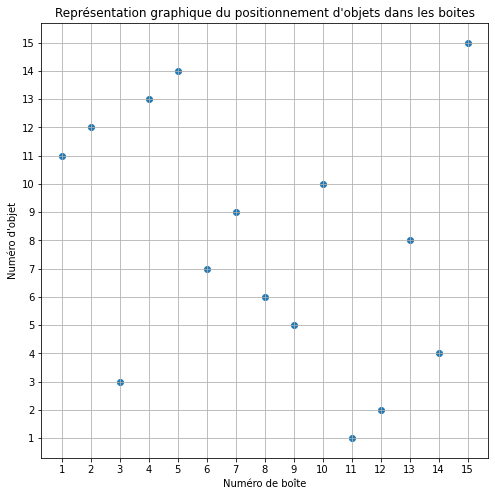

In [ ]:
plt.figure(figsize=(8,8))
row_ix = np.where(np.round(x.value, 1) == 1.)
plt.scatter(row_ix[0]+1,row_ix[1]+1)
plt.xticks(list(range(1,n+1)))
plt.yticks(list(range(1,n+1)))

plt.grid(True)
plt.xlabel('Numéro de boîte')
plt.ylabel("Numéro d'objet")
plt.title("Représentation graphique du positionnement d'objets dans les boites")
plt.show()

## Question 4

In [ ]:
constr4=[x[i,2]+sum([x[k,3] for k in range(i+1,n)])<=1 for i in range(n)]
constraints_all_4=constraints_all_3+constr4
prob = cp.Problem(objective,constraints_all_4)

result = prob.solve(verbose=False,solver='ECOS_BB')

print('La distance optimale est ',prob.value)
print(' x minimal est ',np.round(x.value, 1))

La distance optimale est  16.20439594722419
 x minimal est  [[-0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  1.  0.  0.  0. -0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -0.]
 [-0. -0.  0. -0. -0. -0.  1. -0. -0. -0.  0.  0. -0. -0. -0.]
 [-0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  1. -0. -0.]
 [-0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  1. -0.]
 [-0. -0.  0. -0.  0. -0. -0. -0.  1. -0.  0.  0. -0. -0. -0.]
 [-0. -0.  0. -0.  0.  1. -0.  0. -0. -0.  0.  0. -0. -0. -0.]
 [ 0. -0.  0. -0.  1. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.]
 [ 0.  1.  0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  1.]
 [ 0.  0.  0.  1.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0.  1. -0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0. 

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


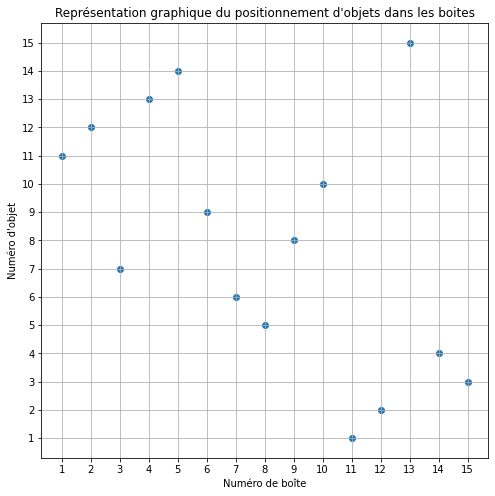

In [ ]:
plt.figure(figsize=(8,8))
row_ix = np.where(np.round(x.value, 1) == 1.)
plt.scatter(row_ix[0]+1,row_ix[1]+1)
plt.xticks(list(range(1,n+1)))
plt.yticks(list(range(1,n+1)))

plt.grid(True)
plt.xlabel('Numéro de boîte')
plt.ylabel("Numéro d'objet")
plt.title("Représentation graphique du positionnement d'objets dans les boites")
plt.show()

## Question 5

In [ ]:
constr5=[x[i,6]+sum([x[k,8] for k in range(i-2)])+sum([x[k,8] for k in range(i+2,n)])<=1 for i in range(n)]
constraints_all_5=constraints_all_4+constr5
prob = cp.Problem(objective,constraints_all_5)

result = prob.solve(verbose=False,solver='ECOS_BB')

print('La distance optimale est ',prob.value)
print(' x minimal est ',np.round(x.value, 1))

La distance optimale est  15.90546202154168
 x minimal est  [[-0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  1.  0.  0.  0. -0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  1.  0.  0. -0.]
 [-0. -0. -0.  0. -0. -0. -0. -0.  0. -0.  0.  0.  1.  0. -0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  1. -0.]
 [-0. -0. -0.  0.  0. -0.  1. -0.  0. -0.  0.  0. -0.  0. -0.]
 [-0. -0.  0.  0.  0.  0. -0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-0. -0. -0.  0.  0.  1. -0.  0. -0.  0.  0.  0. -0.  0. -0.]
 [-0. -0.  0.  1.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0.  1.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0.  0.  0.  0.  0. -0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0.]
 [ 0.  1. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0. -0. -0.  0. -0. -0.  1.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0.  0. 

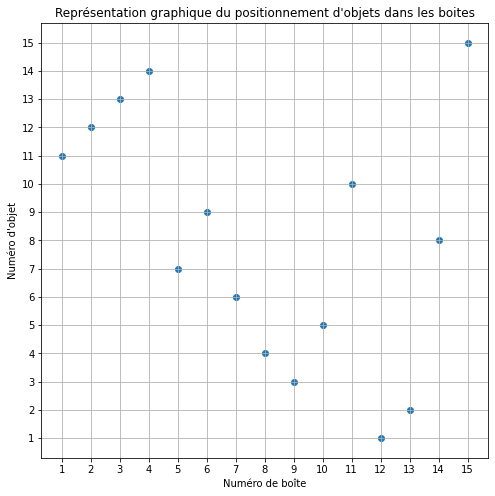

In [ ]:
plt.figure(figsize=(8,8))
row_ix = np.where(np.round(x.value, 1) == 1.)
plt.scatter(row_ix[0]+1,row_ix[1]+1)
plt.xticks(list(range(1,n+1)))
plt.yticks(list(range(1,n+1)))

plt.grid(True)
plt.xlabel('Numéro de boîte')
plt.ylabel("Numéro d'objet")
plt.title("Représentation graphique du positionnement d'objets dans les boites")
plt.show()

## Question 6

Afin de vérifier que la solution est unique, on ajoute la contrainte que $x \neq x_{0}$ avec $x_{0}$ la solution qu'on a trouvé précédemment. 



# Partie 2.2 

In [ ]:
## Ouvrir fichier 
text_file = open("/home/hamza/ProbaInterception.txt", "r")
lines = text_file.read().split('\n')
prob_intercept = np.array([ line.split() for line in lines if len(line)!=0 ])
prob_intercept = prob_intercept.astype(float)
## On remplace les NaN par des 1 pour que la minimisation fonctionne
where_are_NaNs = np.isnan(prob_intercept)
prob_intercept[where_are_NaNs] = 1


n=len(prob_intercept)
agents_a_atteindre=list(range(1,n))
agents_start=[0]
list_prob=[]
list_sommet=[]

while len(agents_a_atteindre)>0 :
    A=prob_intercept[agents_start]
    i,j=np.unravel_index(A.argmin(), A.shape)
    i=agents_start[i]
    list_sommet.append([i,j])
    agents_start.append(j)
    list_prob.append(A.min())
    for i in agents_start :
        prob_intercept[i,j]=1
        prob_intercept[j,i]=1
    agents_a_atteindre.remove(j)
    
    

Maintenant qu'on a le chemin du message, on va calculer la probabilité d'interception. 
Pour ceci on calcule la probabilité de non interception, exprimée comme le produit des probabilité de non interception individuelles , de l'individu i qui transmet le message à celui qui le reçoit. Ainsi: 
$$p_{nonintercept} =  \prod_{i=1}^{p}(1 - p_{intercept}(r_{i}|e_{i}))$$
avec p le nombre d'itérations totales, $r_{i}$ celui qui reçoit le message à l'itération i et $e_{i}$ celui qui l'envoie.
On déduit la probabilité d'interception comme : 
 $$p_{intercept}=1-p_{nonintercept}$$

In [ ]:
prob_not_intercept = np.prod([1 - prob for prob in list_prob])
prob_intercept = 1 - prob_not_intercept

print("Probabilité totale d'interception : ", prob_intercept)
print("Cheminement du message ",list_sommet)

Probabilité totale d'interception :  0.5809187658378594
Cheminement du message  [[0, 11], [0, 5], [5, 13], [13, 10], [5, 14], [13, 2], [2, 6], [10, 8], [8, 3], [3, 1], [3, 7], [2, 4], [4, 9], [4, 12]]


### Représentation graphique 

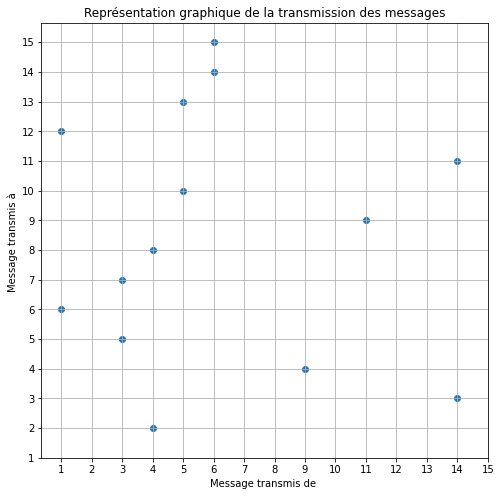

In [ ]:
plt.figure(figsize=(8,8))

array=np.array([[1 if [i,j] in list_sommet else 0 for i in range(n)  ] for j in range(n)])
row_ix = np.where(array == 1)
plt.scatter(row_ix[1]+1,row_ix[0]+1)
plt.xticks(list(range(1,n+1)))
plt.yticks(list(range(1,n+1)))

plt.grid(True)
plt.xlabel('Message transmis de ')
plt.ylabel('Message transmis à ')
plt.title('Représentation graphique de la transmission des messages')
plt.show()

# Exercice 2.3 

In [ ]:
## Changer le path 
text_file = open("/home/hamza/donnees_engin.txt", "r")
tab_n_engins = [line.split() for line in text_file.readlines()][0]
tab_n_engins=[int(float(string)) for string in tab_n_engins ]

In [ ]:
def func_to_minimize(x,n_iter) :
    """
    Fonction à minimiser.
    """
    s=0
    for i in range(1,n_iter):
        to_buy=1000  * x[0,i]
        to_end=1200* x[1,i]
        to_loc=200 * (x[2,i]-x[0,i])
        s+= to_buy + to_loc + to_end
    return s

In [ ]:
n_iter = len(tab_n_engins)

x = cp.Variable((3,n_iter),integer=True)

objective = cp.Minimize(func_to_minimize(x,n_iter) )


## définir le dernier élement de chaque itération comme le nombre d'engins à l'itération i 
constraints0 = [x[2,i]==x[2,i-1]+x[0,i]-x[1,i] for i in range(1,n_iter)]

# Le nombre d'engins à l'itération i doit être supérieur ou égal au nombre nécessaire
constraints1 = [x[2,i]>=tab_n_engins[i] for i in range(n_iter)]

## On initialise 
constraints2 = [x[:,0]==[tab_n_engins[0],0,tab_n_engins[0]]]

# tous les xi doivent être positifs
constraints3=  [x[k,j]>=0 for k in range(3) for j in range(n_iter)]

# le nombre d'engins à la fin doit être égal au nombre nécessaire final 
constr_end = [x[2,-1]==tab_n_engins[-1]]

constraints  = constraints0+constraints1+constraints2+constraints3+constr_end
prob = cp.Problem(objective,constraints)
result = prob.solve(verbose=False,solver='ECOS_BB')



### Résultats 

In [ ]:
from prettytable import PrettyTable


x_result= np.round(x.value,1)
## calcul cout
cout_total = [0]
for i in range(len(tab_n_engins)) :
    cout_achat = 1000 * int(x_result[0,i])
    cout_location = 200 * (int(x_result[2,i])- int(x_result[0,i]))
    cout_vente = 1200 * int(x_result[1,i])
    cout_total.append(cout_total[-1]+cout_achat + cout_vente + cout_location) 
cout_total.pop(0)

table_cout = PrettyTable()

table_cout.add_column("Iteration ",range(1,n_iter+1))
table_cout.add_column("Achat",x_result[0,:].astype(np.int32))
table_cout.add_column("Vente",x_result[1,:].astype(np.int32))
table_cout.add_column("Nombre d'engins à cette itération",x_result[2,:].astype(np.int32))
table_cout.add_column("Coût cumulatif",cout_total)
table_cout.add_row([100,0,129,0,cout_total[-1]+129*1200])
print(table_cout)

+------------+-------+-------+-----------------------------------+----------------+
| Iteration  | Achat | Vente | Nombre d'engins à cette itération | Coût cumulatif |
+------------+-------+-------+-----------------------------------+----------------+
|     1      |   36  |   0   |                 36                |     36000      |
|     2      |   25  |   0   |                 61                |     68200      |
|     3      |   23  |   0   |                 84                |     103400     |
|     4      |   3   |   0   |                 87                |     123200     |
|     5      |   34  |   0   |                121                |     174600     |
|     6      |   0   |   0   |                121                |     198800     |
|     7      |   0   |   0   |                121                |     223000     |
|     8      |   0   |   0   |                121                |     247200     |
|     9      |   0   |   0   |                121                |     27140

### Plot du nombre d'engins en fonction de l'étape 

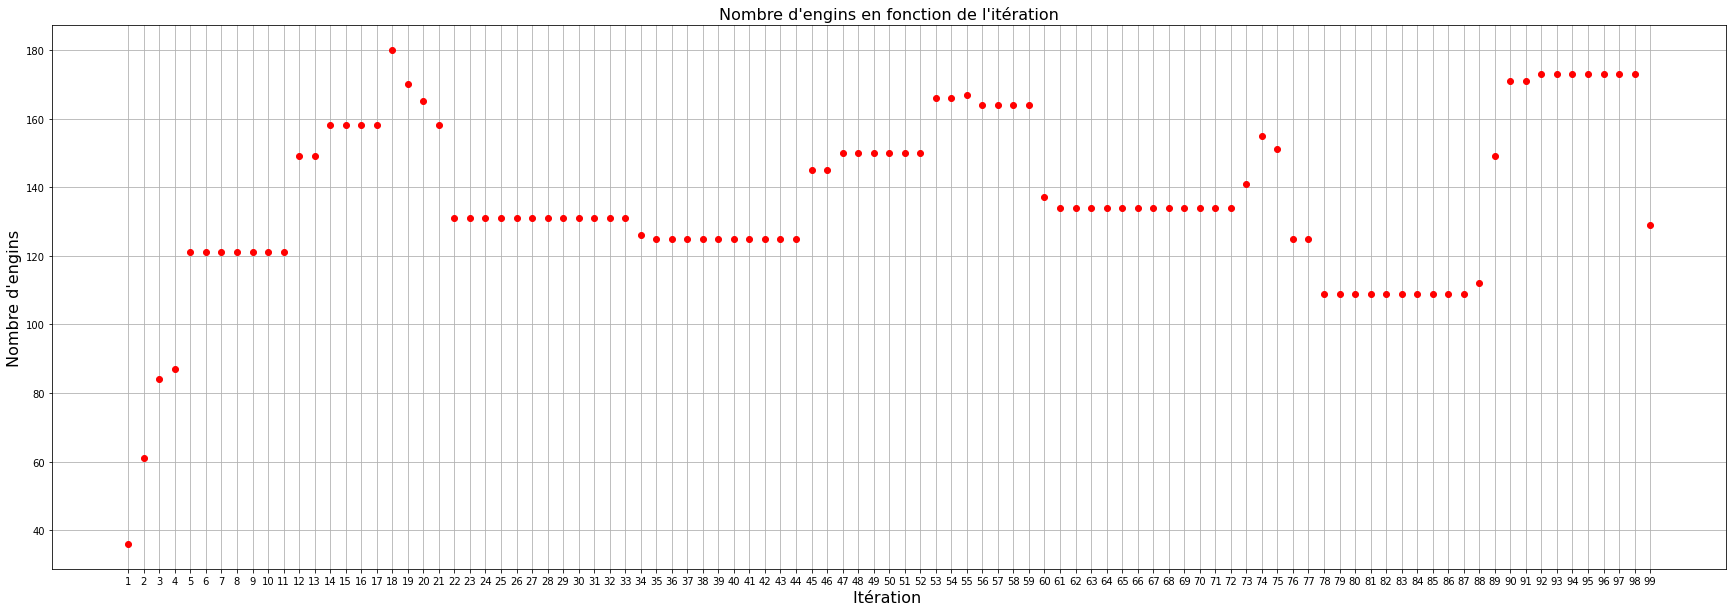

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(range(1,n_iter+1),x_result[2,:],'ro')
plt.xticks(list(range(1,n_iter+1)))

plt.grid(True)
plt.xlabel('Itération ', size=16)
plt.ylabel("Nombre d'engins", size=16)
plt.title("Nombre d'engins en fonction de l'itération", size=16)
plt.show()

## Problème 3 

## Méthode gloutonne 

Dans cette méthode , on tire N couples (a,b) qui respectent les contraintes . Ensuite, on détermine l'ensemble des points qui ne sont pas dominés parmi les N. Ces points là forment alors le front de Pareto. 

In [ ]:
def generate_example():
    a = np.random.uniform(0.02,1,1)
    b = np.random.uniform(0.,a-0.01,1)
    return (a[0] , b[0])
def calculate_p_d(a_b_list):
    res=[]
    for a,b in a_b_list :
        p=a**2-b**2
        d=(10**(-4))/(10**(-2)+a**4-b**4)
        res.append((p,d))
    return res
def check_domination(couple_p_d,list_p_d,i) : 
    p,d=couple_p_d
    for k,(p_bis,d_bis) in enumerate(list_p_d) :
        if k==i :
            continue
        if (p_bis <= p and  d_bis <= d) and  (p_bis < p or d_bis < d ):
            return True
    return False
        
def get_pareto_front(N) :
    """
    Approximate pareto front with greedy algorithm.
    """
    a_b_list = [generate_example() for k in range(N)]
    
    list_p_d = calculate_p_d (a_b_list)
    pareto=[]
    for i,couple_p_d in enumerate(list_p_d) :
        if (check_domination(couple_p_d, list_p_d,i)==False):
            pareto.append(couple_p_d)
            
    return pareto
        

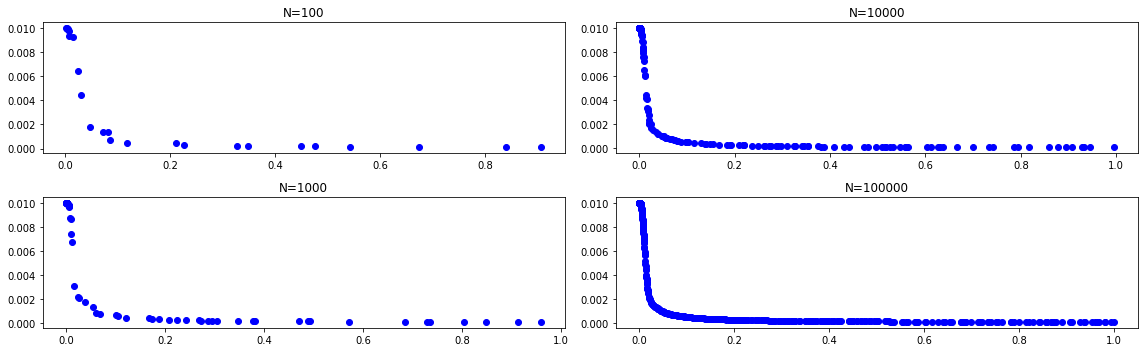

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 5))
tab_axes=[[0,0],[1,0],[0,1],[1,1]]
tab_N = [100, 1000,10000,100000]
for i,N in enumerate(tab_N) :
    rest=get_pareto_front(N=N) 
    
    k,j=tab_axes[i]
    ax[k][j].plot([res[0] for res in rest ],[res[1] for res in rest] ,'bo' )
    #ax[k][j].legend(loc="upper right")
    #plt.legend()
    ax[k][j].set_title('N={}'.format(N))

fig.tight_layout()
#plt.subplots_adjust(bottom=0., right=0.8, top=)
plt.show()  



On remarque qu'il nous faut un N assez grand pour former un front de Pareto visualisable. Ceci a notamment des répercussions sur l'évaluation des objectifs , qu'on doit réaliser aussi pour des exemples parmi les N qui ne forment pas le front.

De plus d'après les graphes, le front de Pareto a une allure convexe.

## Méthode plus sophistiquée 

Ici , on va essayer de trouver le front de pareto en minimisant le problème $$ p(a,b)+ \alpha \times d(a,b),\text{ avec } \alpha \in [0 , + \infty[$$

In [ ]:
def func_to_minimize(x,alpha) :
    p=x[0]**2-x[1]**2
    d=(10**(-4))/(10**(-2)+x[0]**4-x[1]**4)
    return p + alpha * d 

In [ ]:
from scipy.optimize import NonlinearConstraint

tab_alphas = np.linspace(0,100000,10000)
nlc = lambda x: x[1] - x[0]
A=np.eye(2)
    
constr1 = NonlinearConstraint(nlc,-np.inf, -0.01)
constr2=optimize.LinearConstraint(A=A,lb=[0.02 , 0 ],ub=[1,np.inf])

tab_p=[]
tab_d=[]
for alpha in tqdm(tab_alphas,total = len (tab_alphas)) :
    
    a = np.random.uniform(0.02,1,1)
    b = np.random.uniform(0.,a-0.01,1)
    res=optimize.minimize(lambda x:func_to_minimize(x,alpha), x0=np.array([a[0],b[0]]), constraints=[constr1,constr2], method='trust-constr', tol=1e-6)
    
    x_min = res.x
    tab_p.append(x_min[0]**2-x_min[1]**2)
    tab_d.append((10**(-4))/(10**(-2)+x_min[0]**4-x_min[1]**4))
    


100%|██████████| 10000/10000 [13:12<00:00, 12.62it/s] 


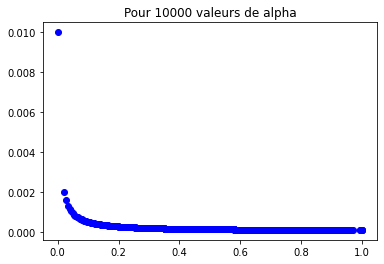

In [ ]:
plt.plot(tab_p,tab_d ,'bo' )
plt.title('Pour 10000 valeurs de alpha')
plt.show()

On remarque que la reconstruction du front de pareto est incomplète dans notre cas, ceci est très probablement dû à un problème de convexité de la courbe dans la partie gauche. Ainsi , même si on a un nombre d'évaluations plus faible de cette méthode pour le même nombre de points pareto-optimaux ( car ici on ne fait l'évaluation que pour les points pareto optimaux , alors que pour la méthode précédente on le faisait aussi pour les points dominés) , on se confronte au problème de la convexité de la courbe pour certains couples (d(a,b) , p(a,b) ).  